Loading Data

In [ ]:
!kaggle datasets download -d erhmrai/ecg-image-data
!unzip ecg-image-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: ECG_Image_data/train/V/V1869.png  
  inflating: ECG_Image_data/train/V/V187.png  
  inflating: ECG_Image_data/train/V/V1870.png  
  inflating: ECG_Image_data/train/V/V1871.png  
  inflating: ECG_Image_data/train/V/V1872.png  
  inflating: ECG_Image_data/train/V/V1874.png  
  inflating: ECG_Image_data/train/V/V1877.png  
  inflating: ECG_Image_data/train/V/V1879.png  
  inflating: ECG_Image_data/train/V/V188.png  
  inflating: ECG_Image_data/train/V/V1880.png  
  inflating: ECG_Image_data/train/V/V1881.png  
  inflating: ECG_Image_data/train/V/V1882.png  
  inflating: ECG_Image_data/train/V/V1883.png  
  inflating: ECG_Image_data/train/V/V1884.png  
  inflating: ECG_Image_data/train/V/V1885.png  
  inflating: ECG_Image_data/train/V/V1886.png  
  inflating: ECG_Image_data/train/V/V1887.png  
  inflating: ECG_Image_data/train/V/V1889.png  
  inflating: ECG_Image_data/train/V/V1892.png  
  inflating: ECG_Image_data/train/V/V18

Class Distribution: {'F': 150, 'M': 150, 'N': 150, 'Q': 150, 'S': 150, 'V': 150}

Training Simple CNN...
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 230ms/step - accuracy: 0.3077 - auc: 0.6219 - loss: 12.7346 - precision: 0.3349 - recall: 0.2277 - val_accuracy: 0.1667 - val_auc: 0.5150 - val_loss: 9.7887 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.5638 - auc: 0.8447 - loss: 8.9761 - precision: 0.6403 - recall: 0.4966 - val_accuracy: 0.2278 - val_auc: 0.5462 - val_loss: 6.9705 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.7016 - auc: 0.9307 - loss: 6.4096 - precision: 0.7499 - recall: 0.6279 - val_accuracy: 0.1667 - val_auc: 0.5584 - val_loss: 5.1506 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accurac

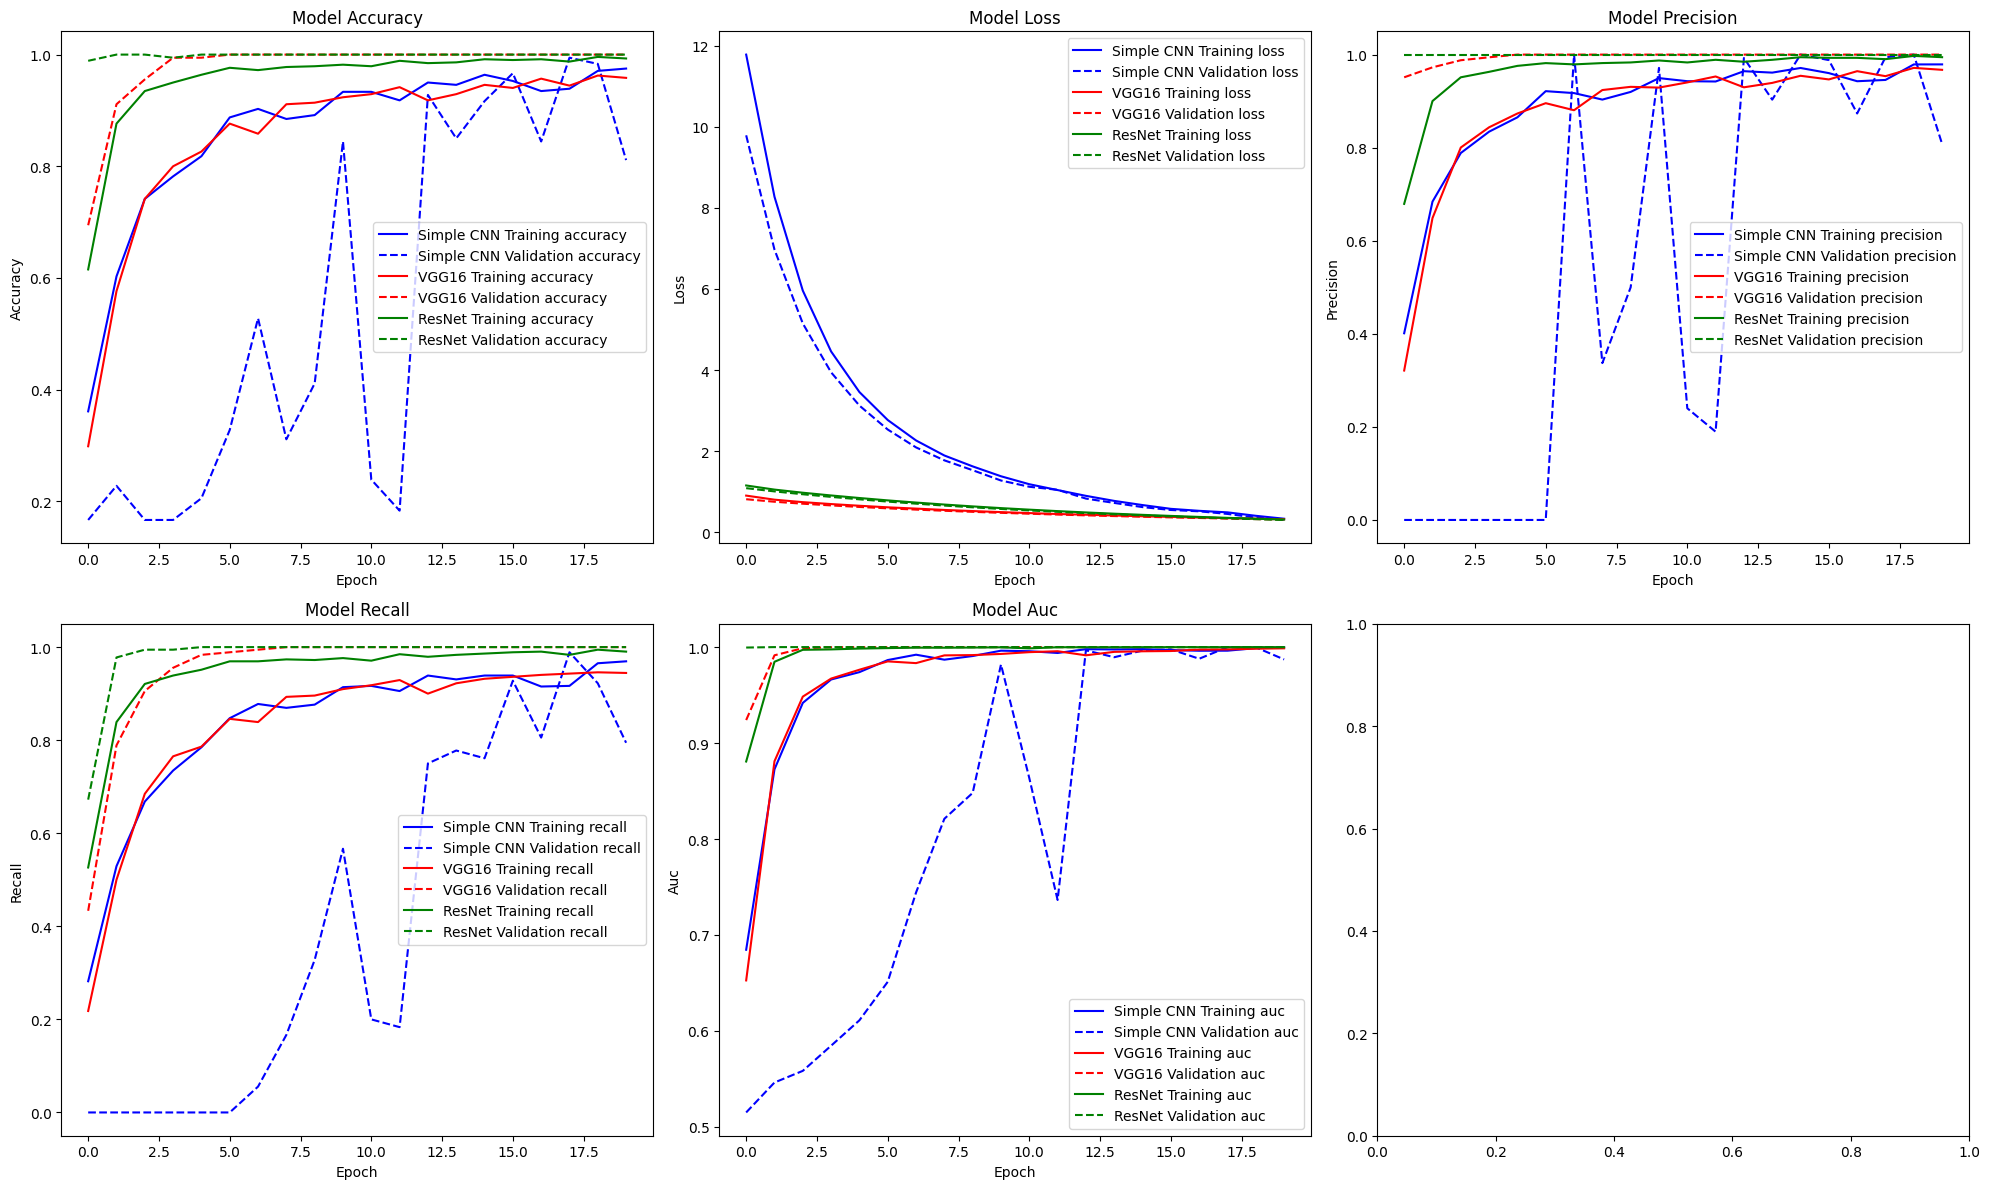


Final metrics for Simple CNN:
accuracy: 0.8111
precision: 0.8079
recall: 0.7944
auc: 0.9871

Final metrics for VGG16:
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
auc: 1.0000

Final metrics for ResNet:
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
auc: 1.0000


In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
NUM_CLASSES = 6
EPOCHS = 20
AUTO = tf.data.AUTOTUNE

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        modulating_factor = tf.pow(1. - y_pred, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_loss = alpha_factor * modulating_factor * cross_entropy
        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed

def balanced_data_collection(data_dir):
    image_files = []
    labels = []
    class_names = []

    try:
        class_folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])
        for class_idx, class_name in enumerate(class_folders):
            class_dir = os.path.join(data_dir, class_name)
            class_image_files = []

            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']:
                class_image_files.extend(tf.io.gfile.glob(os.path.join(class_dir, ext)))

            max_samples = min(len(class_image_files), 150)
            class_image_files = class_image_files[:max_samples]

            image_files.extend(class_image_files)
            labels.extend([class_idx] * len(class_image_files))
            class_names.append(class_name)

        print("Class Distribution:", {name: labels.count(i) for i, name in enumerate(class_names)})

    except Exception as e:
        print(f"Error collecting data: {e}")
        return [], [], []

    return image_files, labels, class_names

def create_dataset(image_files, labels, preprocess_fn=None, is_training=True):
    def process_path(file_path, label):
        try:
            img = tf.io.read_file(file_path)
            img = tf.image.decode_image(img, channels=3, expand_animations=False)
            img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

            if preprocess_fn is not None:
                img = preprocess_fn(img)
            else:
                img = tf.cast(img, tf.float32) / 255.0

            if is_training:
                img = tf.image.random_flip_left_right(img)
                img = tf.image.random_brightness(img, 0.2)
                img = tf.image.random_contrast(img, 0.8, 1.2)

        except Exception as e:
            print(f"Error processing image {file_path}: {e}")
            img = tf.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32)

        return img, tf.one_hot(label, NUM_CLASSES)

    dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(image_files))
    dataset = dataset.map(process_path, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def create_simple_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # First Convolutional Block
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

def create_vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

def train_model(model, train_dataset, test_dataset, train_labels, model_name):
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weight_dict = dict(enumerate(class_weights))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=focal_loss(gamma=2., alpha=0.25),
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]

    try:
        history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=test_dataset,
            class_weight=class_weight_dict,
            callbacks=callbacks
        )
        print(f"\nTraining completed for {model_name}")
        return history
    except Exception as e:
        print(f"Training error for {model_name}: {e}")
        return None

def plot_comparison(histories, model_names):
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    colors = ['blue', 'red', 'green']
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        if idx < len(axes):
            for hist, name, color in zip(histories, model_names, colors):
                axes[idx].plot(hist.history[metric],
                             label=f'{name} Training {metric}',
                             color=color, linestyle='-')
                axes[idx].plot(hist.history[f'val_{metric}'],
                             label=f'{name} Validation {metric}',
                             color=color, linestyle='--')

            axes[idx].set_title(f'Model {metric.capitalize()}')
            axes[idx].set_xlabel('Epoch')
            axes[idx].set_ylabel(metric.capitalize())
            axes[idx].legend()

    plt.tight_layout()
    plt.show()

def main():
    data_dir = 'ECG_Image_data/train'

    # Collect balanced dataset
    image_files, labels, class_names = balanced_data_collection(data_dir)

    if not image_files:
        print("No images found. Check your data directory.")
        return

    # Split data
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels,
        test_size=0.2,
        stratify=labels,
        random_state=42
    )

    # Create datasets for each model
    train_dataset_simple = create_dataset(train_files, train_labels, None, True)
    test_dataset_simple = create_dataset(test_files, test_labels, None, False)

    train_dataset_vgg = create_dataset(train_files, train_labels, vgg_preprocess, True)
    test_dataset_vgg = create_dataset(test_files, test_labels, vgg_preprocess, False)

    train_dataset_resnet = create_dataset(train_files, train_labels, resnet_preprocess, True)
    test_dataset_resnet = create_dataset(test_files, test_labels, resnet_preprocess, False)

    # Train Simple CNN
    print("\nTraining Simple CNN...")
    simple_cnn = create_simple_cnn()
    simple_history = train_model(simple_cnn, train_dataset_simple, test_dataset_simple,
                               train_labels, "Simple CNN")

    # Train VGG16
    print("\nTraining VGG16 model...")
    vgg_model = create_vgg_model()
    vgg_history = train_model(vgg_model, train_dataset_vgg, test_dataset_vgg,
                             train_labels, "VGG16")

    # Train ResNet
    print("\nTraining ResNet model...")
    resnet_model = create_resnet_model()
    resnet_history = train_model(resnet_model, train_dataset_resnet, test_dataset_resnet,
                                train_labels, "ResNet")

    # Plot comparison
    if all([simple_history, vgg_history, resnet_history]):
        histories = [simple_history, vgg_history, resnet_history]
        model_names = ['Simple CNN', 'VGG16', 'ResNet']
        plot_comparison(histories, model_names)

        # Print final metrics for each model
        for model_name, history in zip(model_names, histories):
            print(f"\nFinal metrics for {model_name}:")
            for metric in ['accuracy', 'precision', 'recall', 'auc']:
                val_metric = f'val_{metric}'
                final_value = history.history[val_metric][-1]
                print(f"{metric}: {final_value:.4f}")
    else:
        print("Training failed for one or more models")

if __name__ == "__main__":
    main()